In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv('Titanic_train.csv')
test = pd.read_csv('Titanic_test.csv')

## Exploratory Data Analysis

In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
num_features = ['Age', 'Fare', 'SibSp', 'Parch']

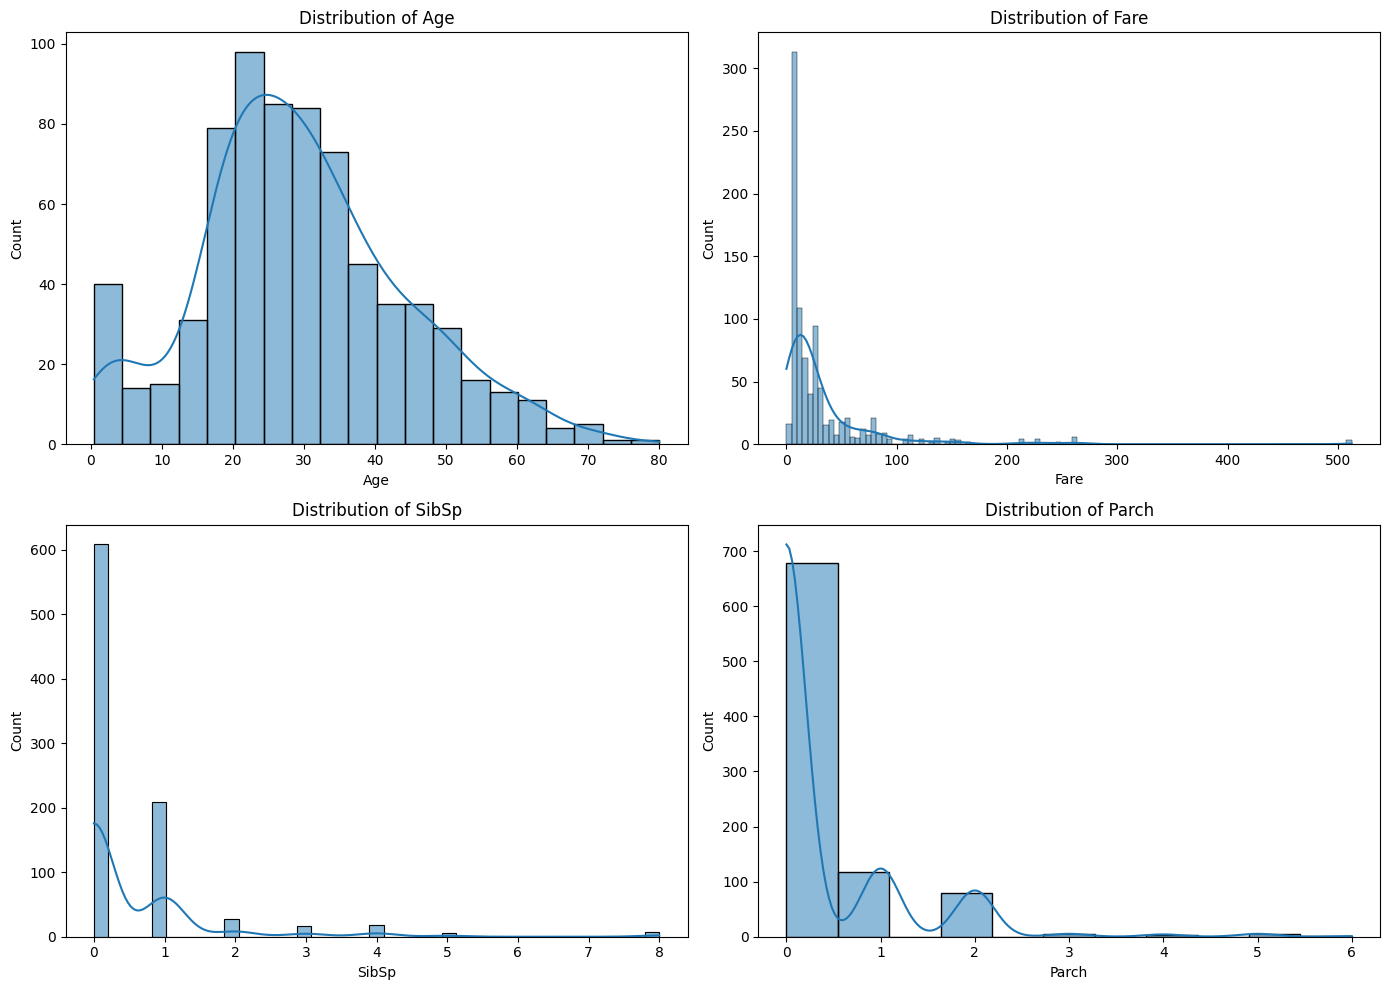

In [11]:
plt.figure(figsize=(14,10))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

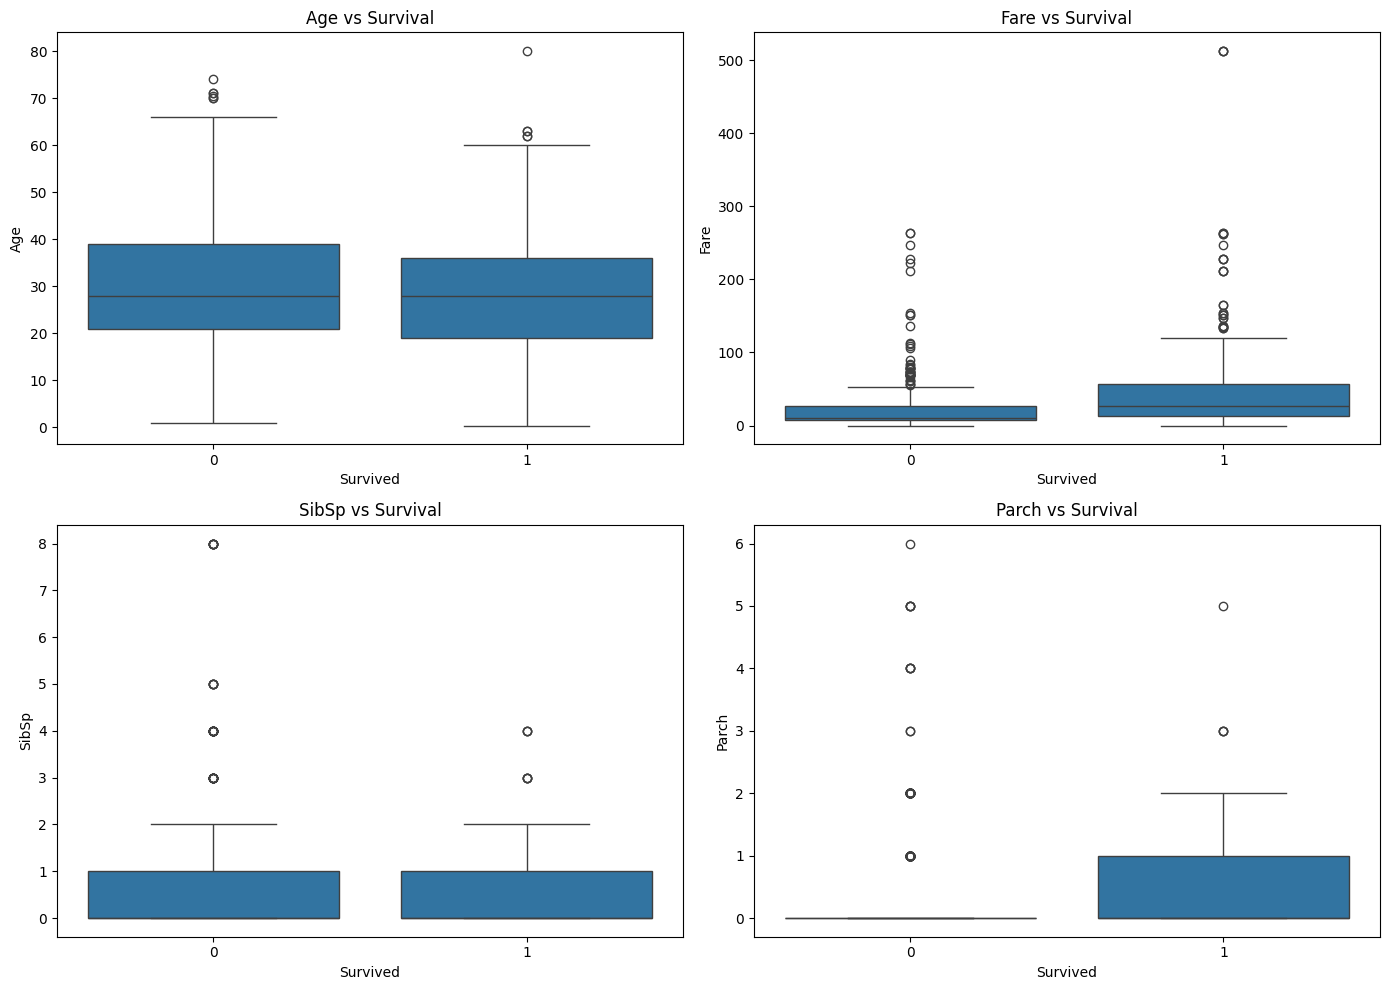

In [12]:
plt.figure(figsize=(14,10))
for i, col in enumerate(num_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=train['Survived'], y=train[col])
    plt.title(f'{col} vs Survival')
plt.tight_layout()
plt.show()

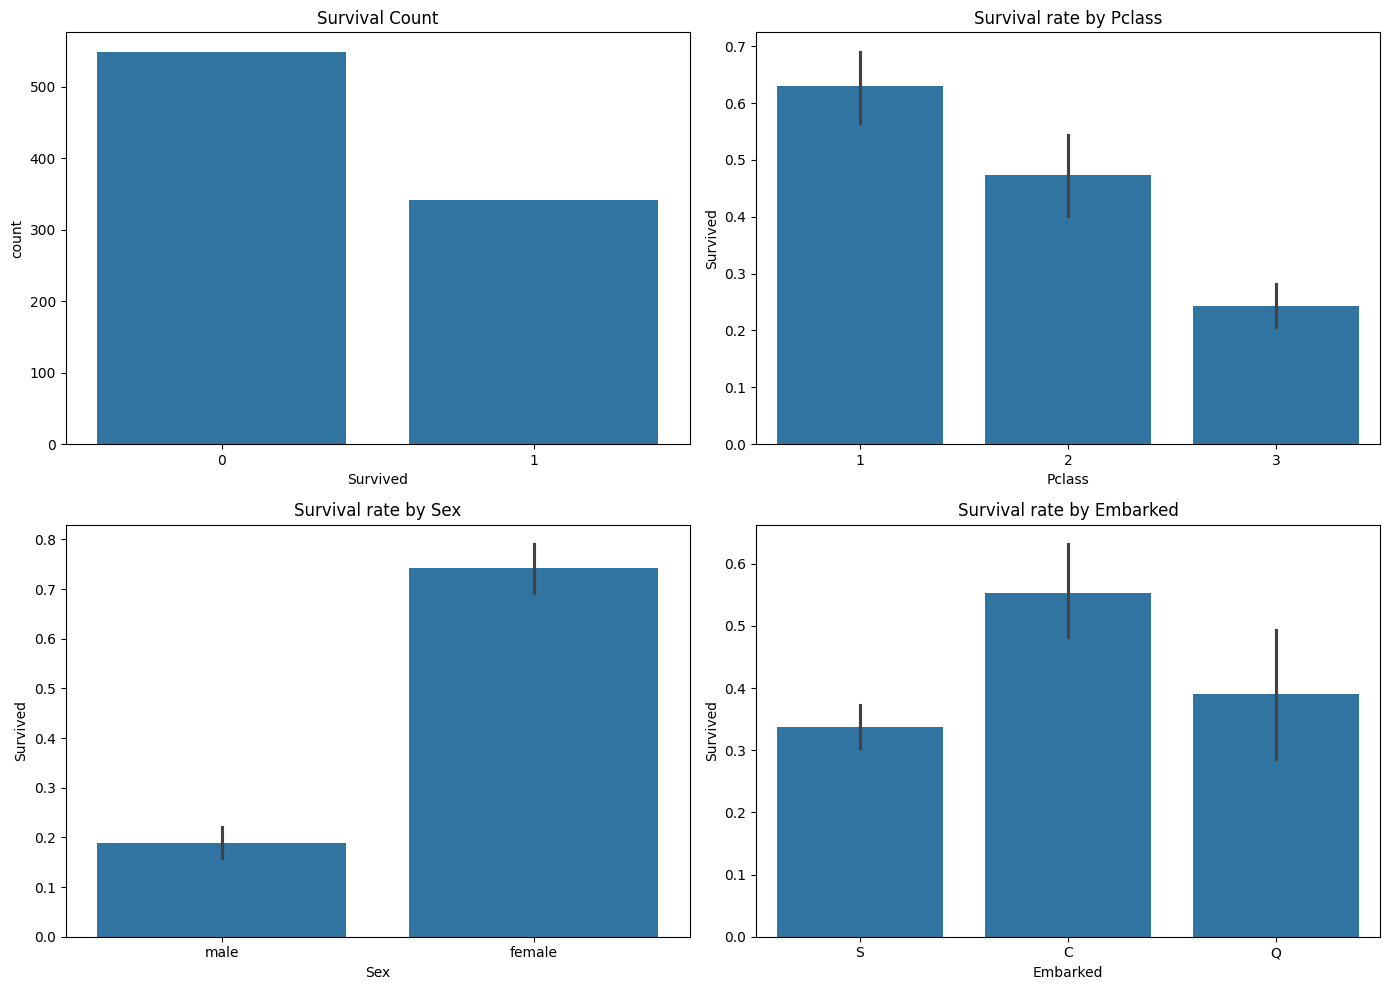

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))
sns.countplot(x='Survived', data=train, ax=axes[0,0])
axes[0,0].set_title('Survival Count')

categorical_features = ['Pclass', 'Sex', 'Embarked']
for i, col in enumerate(categorical_features):
    sns.barplot(x=col, y='Survived', data=train, ax=axes[(i+1)//2, (i+1)%2])
    axes[(i+1)//2, (i+1)%2].set_title(f'Survival rate by {col}')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [15]:
train['TrainSplit'] = 1
test['TrainSplit'] = 0
test['Survived'] = np.nan 
full_data = pd.concat([train, test], sort=False)

In [16]:
full_data['Age'].fillna(full_data['Age'].median(), inplace=True)
full_data['Fare'].fillna(full_data['Fare'].median(), inplace=True)
full_data['Embarked'].fillna(full_data['Embarked'].mode()[0], inplace=True)

In [17]:
full_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

In [18]:
full_data['Sex'] = full_data['Sex'].map({'male': 0, 'female': 1})

In [19]:
full_data = pd.get_dummies(full_data, columns=['Embarked', 'Pclass'], drop_first=True)

In [20]:
train_processed = full_data[full_data['TrainSplit'] == 1].drop(['TrainSplit'], axis=1)
test_processed = full_data[full_data['TrainSplit'] == 0].drop(['TrainSplit', 'Survived'], axis=1)

## Building Predictive Models

In [21]:
X = train_processed.drop('Survived', axis=1)
y = train_processed['Survived'].astype(int)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

In [28]:
lgbm_model = lgb.LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_val)
evaluate_model(y_val, y_pred_lgbm, "LightGBM")

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [30]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
evaluate_model(y_val, y_pred_xgb, "XGBoost")

XGBoost Performance:
Accuracy: 0.8212290502793296
Precision: 0.7916666666666666
Recall: 0.7702702702702703
F1 Score: 0.7808219178082192

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       105
           1       0.79      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
print("\nCross-validation scores:")
lgbm_cv_scores = cross_val_score(lgbm_model, X, y, cv=5, scoring='accuracy')
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print(f"LightGBM CV accuracy: {lgbm_cv_scores.mean():.4f} +/- {lgbm_cv_scores.std():.4f}")
print(f"XGBoost CV accuracy: {xgb_cv_scores.mean():.4f} +/- {xgb_cv_scores.std():.4f}")


Cross-validation scores:
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

##  Hyperparameter tuning with GridSearchCV 

In [33]:
param_grid = {
     'num_leaves': [31, 50],
     'max_depth': [10, 20, -1],
     'learning_rate': [0.05, 0.1],
     'n_estimators': [100, 200]
}
grid_search = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best LightGBM params:", grid_search.best_params_)
y_pred_best = best_model.predict(X_val)
evaluate_model(y_val, y_pred_best, "Tuned LightGBM")

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Visualize feature importance from LightGBM and XGBoost

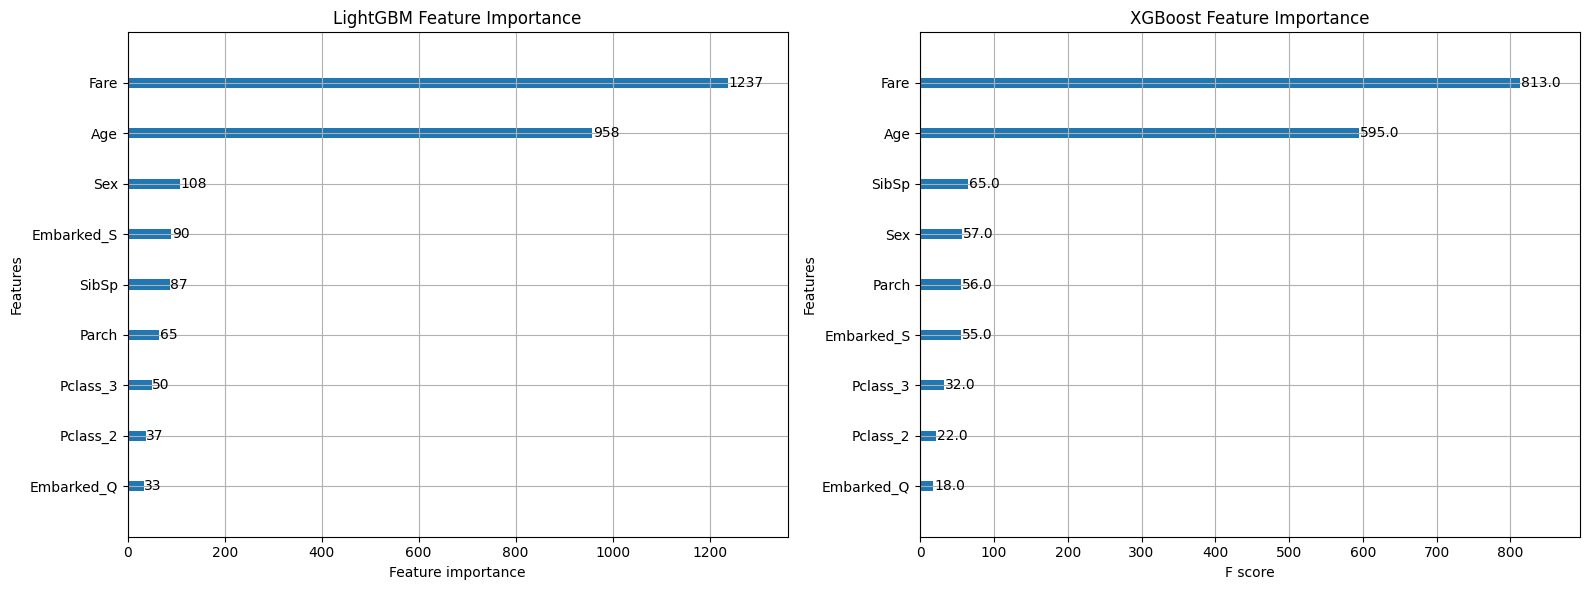

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

lgb.plot_importance(lgbm_model, max_num_features=10, ax=axes[0], title='LightGBM Feature Importance')
xgb.plot_importance(xgb_model, max_num_features=10, ax=axes[1], title='XGBoost Feature Importance')

plt.tight_layout()
plt.show()